# Análisis de Optimización Bayesianas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import os
os.chdir("/mnt/c/Users/ignac/OneDrive/Escritorio/EyF 2022/recuperatorio/mastercard_recovery")

In [2]:
from io import BytesIO, StringIO
from google.cloud import storage
from google.oauth2 import service_account

def get_byte_fileobj(project: str,
                     bucket: str,
                     path: str,
                     service_account_credentials_path: str = None) -> BytesIO:
    """
    Retrieve data from a given blob on Google Storage and pass it as a file object.
    :param path: path within the bucket
    :param project: name of the project
    :param bucket_name: name of the bucket
    :param service_account_credentials_path: path to credentials.
           TIP: can be stored as env variable, e.g. os.getenv('GOOGLE_APPLICATION_CREDENTIALS_DSPLATFORM')
    :return: file object (BytesIO)
    """
    blob = _get_blob(bucket, path, project, service_account_credentials_path)
    byte_stream = BytesIO()
    blob.download_to_file(byte_stream)
    byte_stream.seek(0)
    return byte_stream

def get_bytestring(project: str,
                   bucket: str,
                   path: str,
                   service_account_credentials_path: str = None) -> bytes:
    """
    Retrieve data from a given blob on Google Storage and pass it as a byte-string.
    :param path: path within the bucket
    :param project: name of the project
    :param bucket_name: name of the bucket
    :param service_account_credentials_path: path to credentials.
           TIP: can be stored as env variable, e.g. os.getenv('GOOGLE_APPLICATION_CREDENTIALS_DSPLATFORM')
    :return: byte-string (needs to be decoded)
    """
    blob = _get_blob(bucket, path, project, service_account_credentials_path)
    s = blob.download_as_string()
    return s


def _get_blob(bucket_name, path, project, service_account_credentials_path):
    credentials = service_account.Credentials.from_service_account_file(
        service_account_credentials_path) if service_account_credentials_path else None
    storage_client = storage.Client(project=project, credentials=credentials)
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(path)
    return blob

In [3]:
df1 = pd.read_csv("./exp/BO2802/BO2802.txt", sep="\t") # LGBM s/ creación de features
df1['fecha'] = pd.to_datetime(df1['fecha'])

df2 = pd.read_csv("./exp/BO0203/BO0203.txt", sep="\t") # LGBM acotando espacio de hyperparámetros
df2['fecha'] = pd.to_datetime(df2['fecha'])

df3 = pd.read_csv("./exp/BO0803/BO0803.txt", sep="\t") # LGBM creación de features (ratios, rpart.rules, xgboost)
df3['fecha'] = pd.to_datetime(df3['fecha'])

In [4]:
fileobj = get_byte_fileobj(project = 'tidal-turbine-379816', 
                           bucket = 'dmeyf_recu', 
                           path = 'exp/BO0803b/BO0803b.txt',
                           service_account_credentials_path = 'creds/tidal-turbine-379816-21eb02bea5be.json' )
df4 = pd.read_csv(fileobj, sep = "\t")

In [5]:
lm = pd.read_csv("./exp/LINEA_MUERTE_MC/salidas_MC.csv.gz")

# Intervalo de confianza Línea de Muerte
lm_data = lm.ganancia_test.to_list()
  
# create 90% confidence interval
interval_lm = st.t.interval(confidence = 0.95, df=len(lm_data)-1,
              loc=np.mean(lm_data),
              scale=st.sem(lm_data))

In [6]:
log_reg = pd.read_csv("./exp/XGB_FE_LOG_REG/salidas_MC.csv.gz")

# Intervalo de confianza XGB+LogReg
log_reg_data = log_reg.ganancia_test.to_list()
  
# create 90% confidence interval
interval_log_reg = st.t.interval(confidence = 0.95, df=len(log_reg_data)-1,
              loc=np.mean(log_reg_data),
              scale=st.sem(log_reg_data))

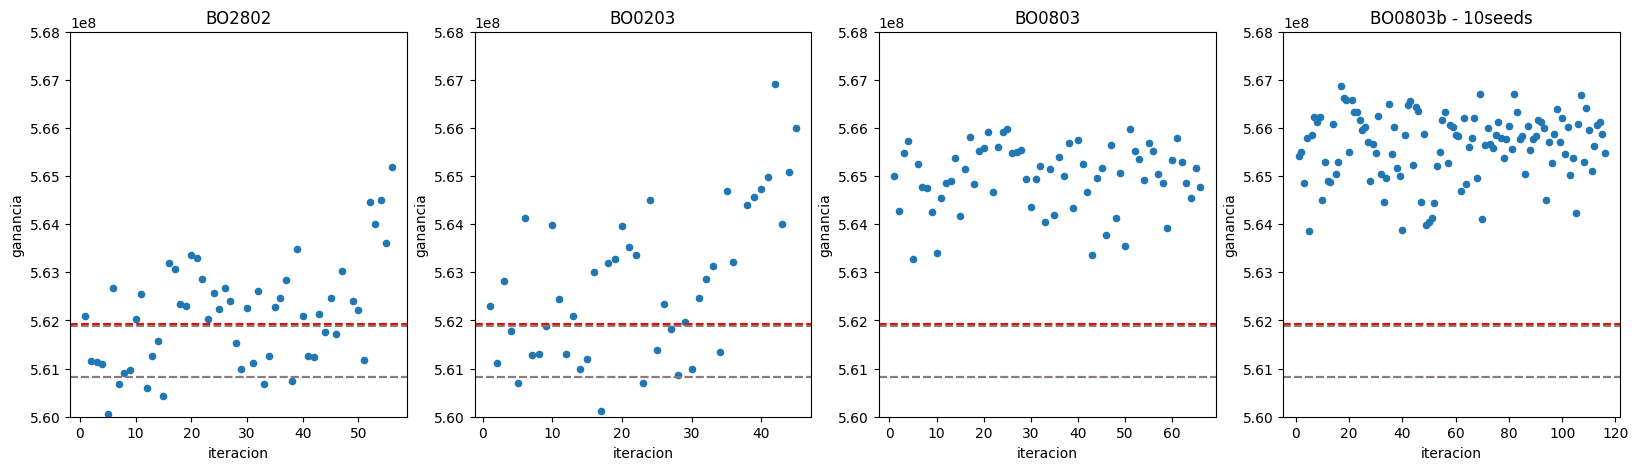

In [7]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,5))

df1.plot(kind = "scatter", x = "iteracion", y="ganancia", ax= axs[0])
df2.plot(kind = "scatter", x = "iteracion", y="ganancia", ax= axs[1])
df3.plot(kind = "scatter", x = "iteracion", y="ganancia", ax= axs[2])
df4.plot(kind = "scatter", x = "iteracion", y="ganancia", ax= axs[3])

[axs[0].axhline(y=i, linestyle='--', color = 'r') for i in interval_lm]
[axs[1].axhline(y=i, linestyle='--', color = 'r') for i in interval_lm]
[axs[2].axhline(y=i, linestyle='--', color = 'r') for i in interval_lm]
[axs[3].axhline(y=i, linestyle='--', color = 'r') for i in interval_lm]

[axs[0].axhline(y=i, linestyle='--', color = 'grey') for i in interval_log_reg]
[axs[1].axhline(y=i, linestyle='--', color = 'grey') for i in interval_log_reg]
[axs[2].axhline(y=i, linestyle='--', color = 'grey') for i in interval_log_reg]
[axs[3].axhline(y=i, linestyle='--', color = 'grey') for i in interval_log_reg]

axs[0].set_ylim((5.6*1e8, 5.68*1e8))
axs[1].set_ylim((5.6*1e8, 5.68*1e8))
axs[2].set_ylim((5.6*1e8, 5.68*1e8))
axs[3].set_ylim((5.6*1e8, 5.68*1e8))

axs[0].set_title("BO2802")
axs[1].set_title("BO0203")
axs[2].set_title("BO0803")
axs[3].set_title("BO0803b - 10seeds")

plt.show()

Se vislumbra que los modelos de la optimización bayesiana BO0803b, cuyas ganancias estimadas se calcularon mediante un 10 repeated 5-fold CV, tienen un valor en promedio más alto.

# BO2802

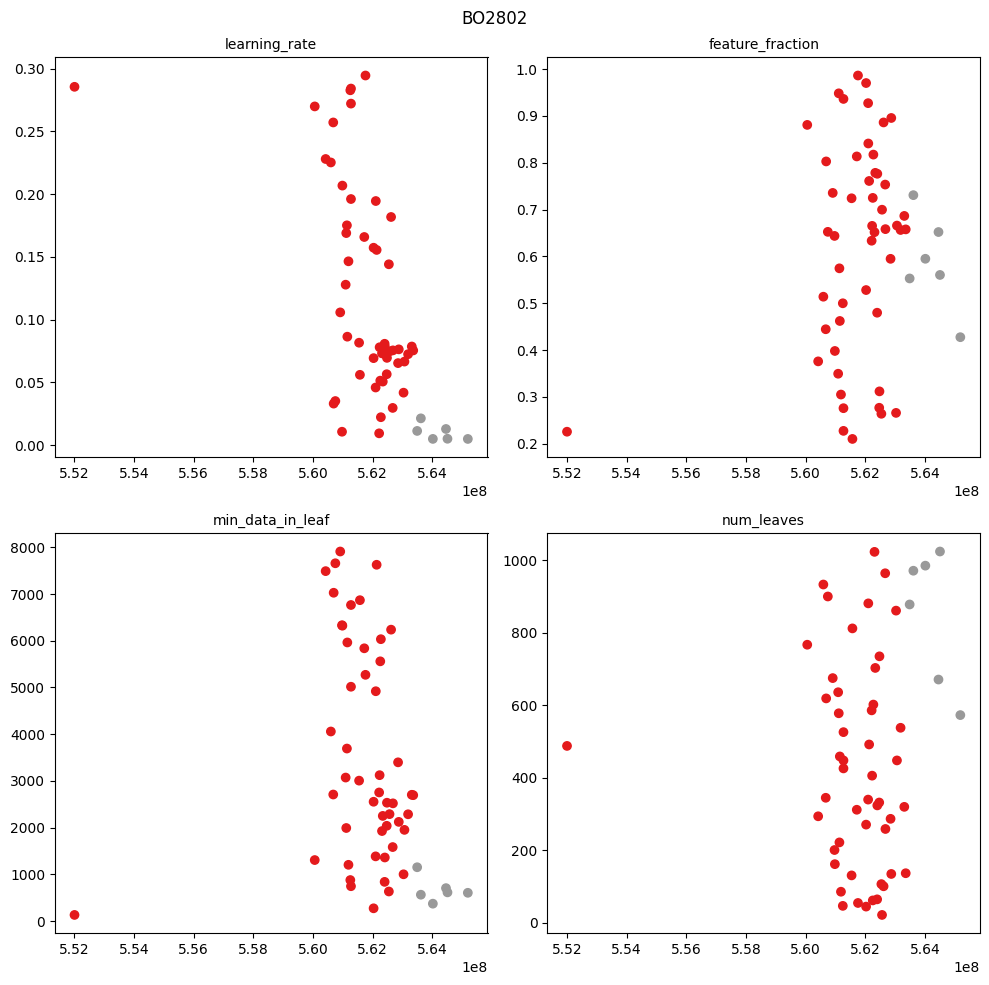

In [8]:
ganancia = df1.ganancia
p = 90
bound = np.percentile(ganancia, p)

ganancia_bool1 = (ganancia>bound)


hs = ['learning_rate','feature_fraction', 'min_data_in_leaf', 'num_leaves']

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (10,10))

axs = axs.flatten()

for i in range(len(hs)):
    axs[i].scatter(x= df1['ganancia'], y = df1[hs[i]], c=ganancia_bool1, cmap=plt.cm.Set1)
    axs[i].set_title(hs[i], fontsize = 10)
    
fig.suptitle("BO2802")

plt.tight_layout()
                                        

# BO0203

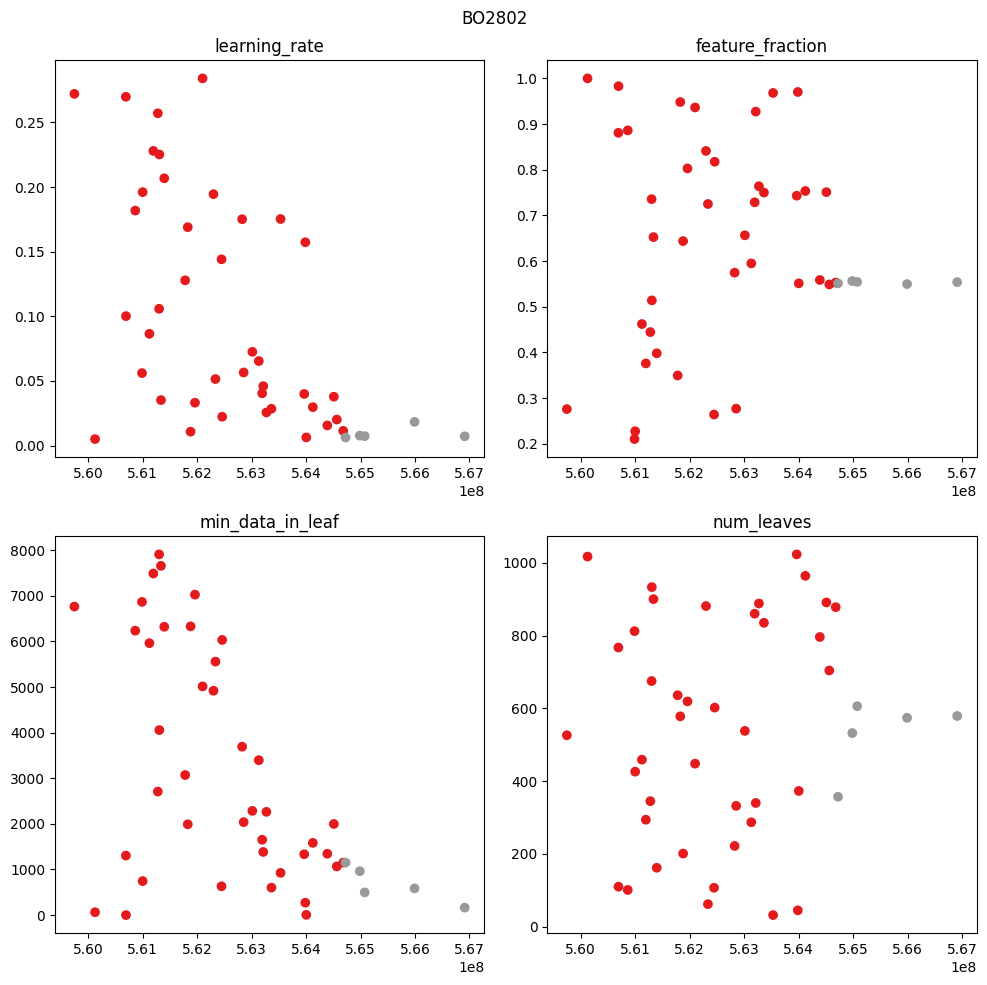

In [9]:
ganancia = df2.ganancia
p = 90
bound = np.percentile(ganancia, p)

ganancia_bool2 = (ganancia>bound)

hs = ['learning_rate','feature_fraction', 'min_data_in_leaf', 'num_leaves']

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (10,10))

axs = axs.flatten()

for i in range(len(hs)):
    axs[i].scatter(x= df2['ganancia'], y = df2[hs[i]], c=ganancia_bool2, cmap=plt.cm.Set1)
    axs[i].set_title(hs[i])

fig.suptitle("BO2802")

plt.tight_layout()
                                        

# BO0803

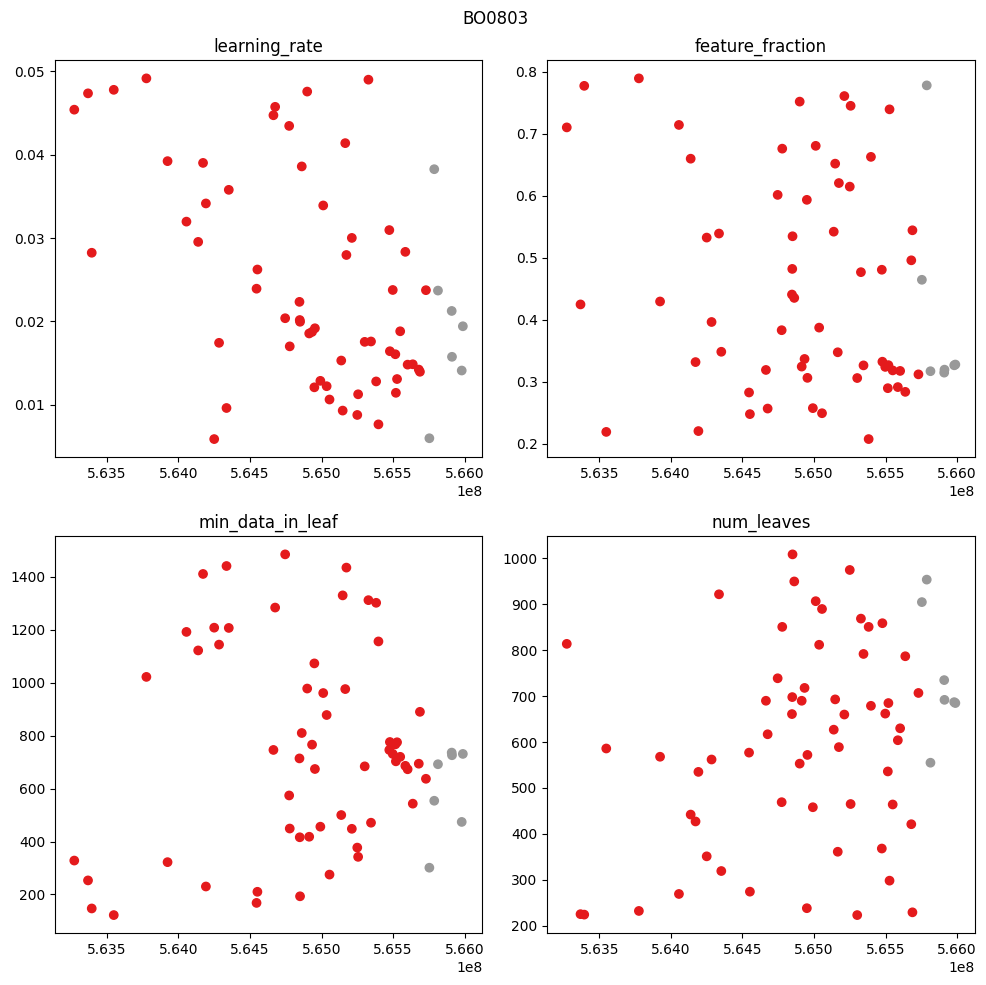

In [10]:
ganancia = df3.ganancia
p = 90
bound = np.percentile(ganancia, p)

ganancia_bool3 = (ganancia>bound)

hs = ['learning_rate','feature_fraction', 'min_data_in_leaf', 'num_leaves']

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (10,10))

axs = axs.flatten()

for i in range(len(hs)):
    axs[i].scatter(x= df3['ganancia'], y = df3[hs[i]], c=ganancia_bool3, cmap=plt.cm.Set1)
    axs[i].set_title(hs[i])

fig.suptitle("BO0803")

plt.tight_layout()

# BO0803b - 10 Repeated 5-fold Cross-Validation

Esta es la corrida que en general posee valores más altos. Nos disponemos a analizarla en profundidad. 

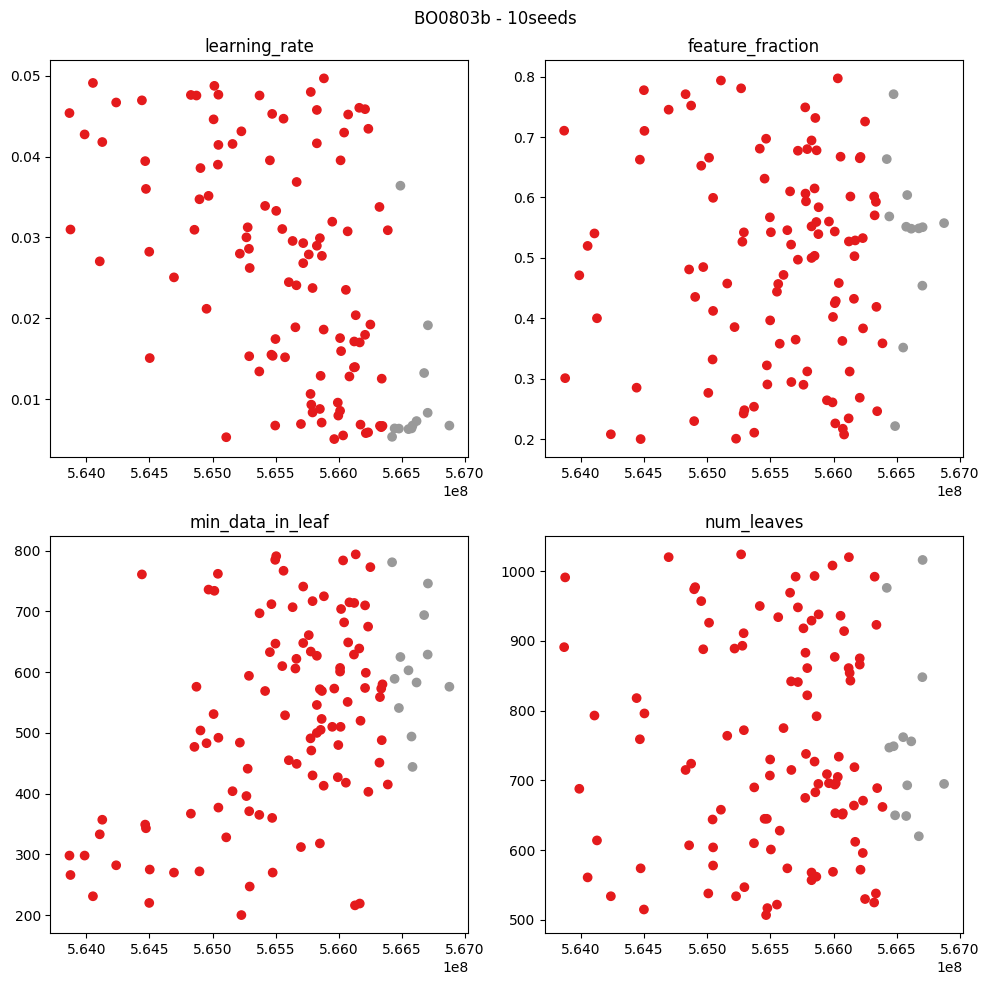

In [11]:
ganancia = df4.ganancia
p = 90
bound = np.percentile(ganancia, p)

ganancia_bool4 = (ganancia>bound)

hs = ['learning_rate','feature_fraction', 'min_data_in_leaf', 'num_leaves']

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (10,10))

axs = axs.flatten()

for i in range(len(hs)):
    axs[i].scatter(x= df4['ganancia'], y = df4[hs[i]], c=ganancia_bool4, cmap=plt.cm.Set1)
    axs[i].set_title(hs[i])

fig.suptitle("BO0803b - 10seeds")

plt.tight_layout()

## Análisis de los clusters generados por la salida de la optimización bayesiana. 

In [12]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage

In [13]:
scaler = StandardScaler()
features = df4[["learning_rate","feature_fraction","min_data_in_leaf","num_leaves","num_iterations"]]
transformer = scaler.fit(features)
scaled_features = transformer.transform(features)

In [14]:
kmeans_kwargs = {
  "init": "random",
  "n_init": 10,
  "max_iter": 300,
  "random_state": 42,
  }
   
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(scaled_features)
  sse.append(kmeans.inertia_)

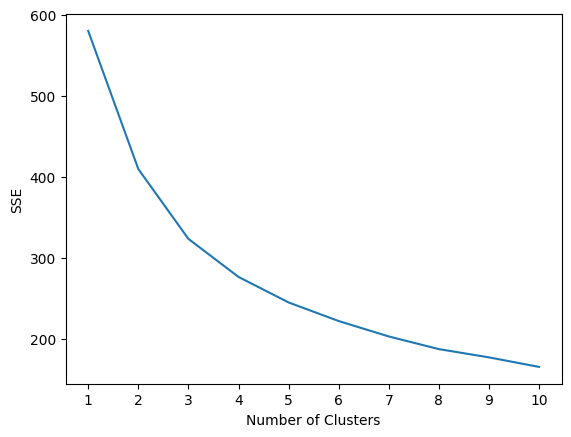

In [15]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [16]:
kl = KneeLocator(
  range(1, 11), sse, curve="convex", direction="decreasing"
  )
kl.elbow

4

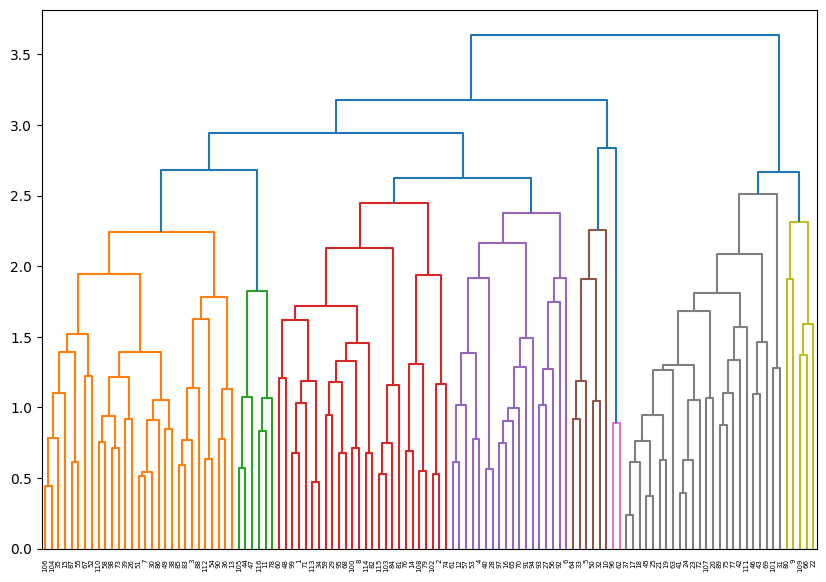

In [17]:
#X = data.iloc[:,1:3].to_numpy()
linked = linkage(scaled_features, 'average')

labelList = df4.iteracion.to_numpy()

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [18]:
kmeans2 = KMeans(
     init="random",
     n_clusters=kl.elbow,
     n_init=10,
     max_iter=300,
     random_state=42)

In [19]:
kmeans2.fit(scaled_features)

KMeans(init='random', n_clusters=4, n_init=10, random_state=42)

In [20]:
 #Agregamos labels de clusters predecidos a cada fila. 
df4['cluster_label'] = kmeans2.labels_

In [21]:
centroides = pd.DataFrame(transformer.inverse_transform(kmeans2.cluster_centers_), columns = ["learning_rate","feature_fraction","min_data_in_leaf","num_leaves","num_iterations"])
centroides['cluster'] = np.unique(kmeans2.labels_)
centroides['ganancia_media'] = df4.groupby('cluster_label')['ganancia'].mean().astype('int')
centroides['ganancia_sd'] = round(df4.groupby('cluster_label')['ganancia'].std(),2)

In [22]:
centroides

,learning_rate,feature_fraction,min_data_in_leaf,num_leaves,num_iterations,cluster,ganancia_media,ganancia_sd
0,0.036686,0.354037,440.413793,616.034483,219.827586,0,565397103,723086.95
1,0.031310,0.505917,668.000000,825.971429,294.171429,1,565686971,476434.89
2,0.024103,0.533394,355.041667,862.750000,304.125000,2,565218416,749353.80
3,0.007645,0.586896,586.071429,698.178571,1004.107143,3,566167642,424951.43


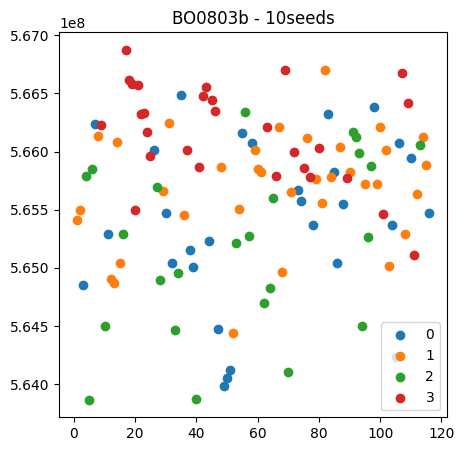

In [23]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(figsize = (5,5))

groups = df4.groupby('cluster_label')
for name, group in groups:
    ax.scatter(group.iteracion, group.ganancia, label=name)

ax.set_title("BO0803b - 10seeds")

plt.legend()
plt.show()

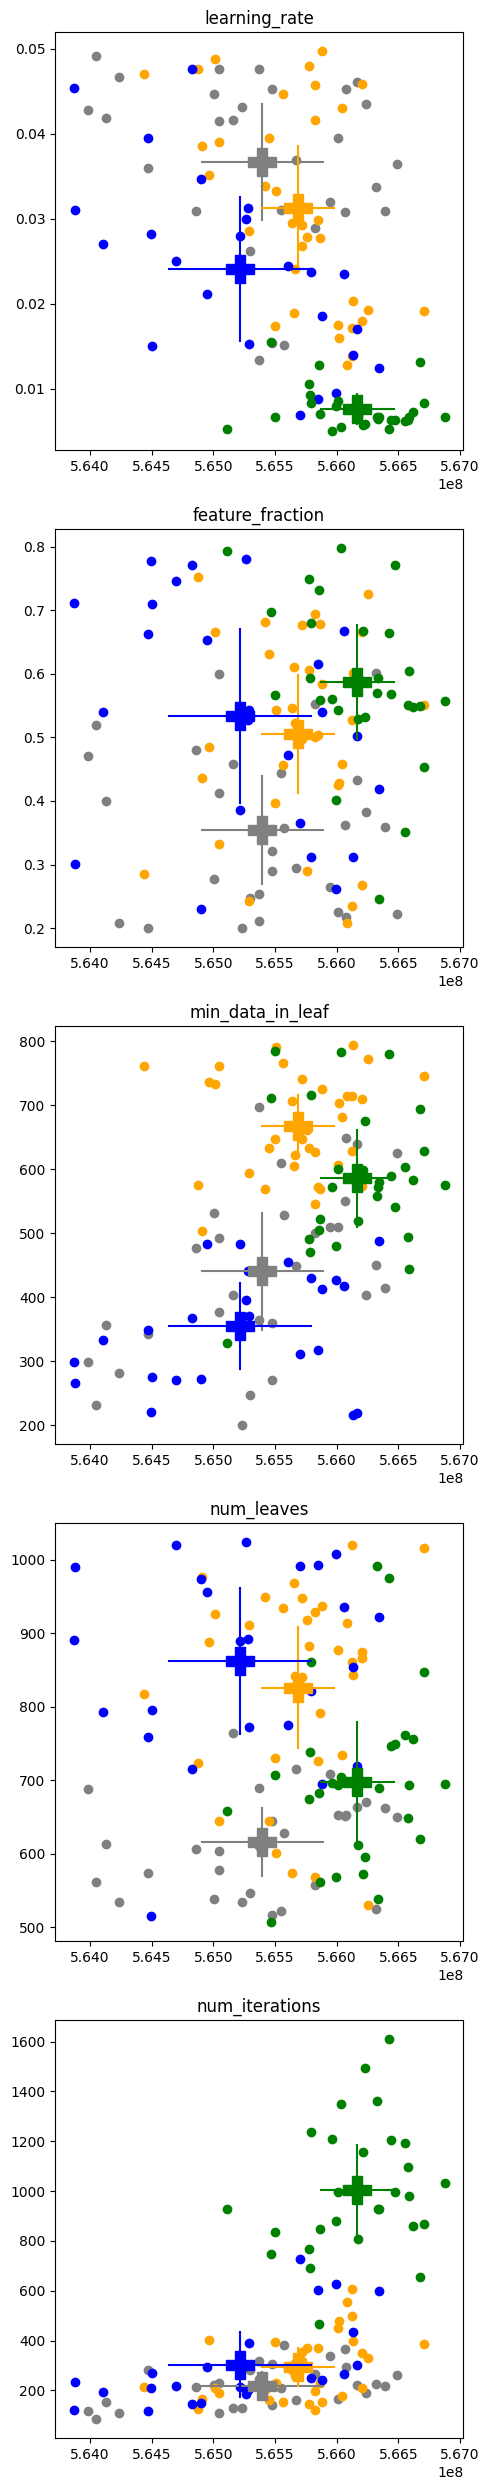

In [24]:
from scipy.stats import t

ganancia = df4.ganancia

hs = ['learning_rate','feature_fraction', 'min_data_in_leaf', 'num_leaves', 'num_iterations']

fig, axs = plt.subplots(ncols = 1, nrows = 5, figsize = (5,25))

axs = axs.flatten()

groups = df4.groupby('cluster_label')
for (name, group), c in zip(groups, ["grey", "orange", "blue", "green"]):
    for i in range(len(hs)):
        x, y  = group['ganancia'], group[hs[i]]
        
        #Dibujo centroies para cada cluster
        centerx, centery = x.mean(), y.mean()
        axs[i].plot(centerx, centery, marker="P", markersize=20, c=c)
        
        conf = 0.999
        
        #Obtengo CI para x para cada cluster
        m, sd, gl = x.mean(), x.std(), len(x)-1
        t_crit = np.abs(t.ppf((1-conf)/2,gl))
        ci_x = (m-(sd*t_crit/np.sqrt(len(x))), m+(sd*t_crit/np.sqrt(len(x))))
        axs[i].plot(ci_x, (centery, centery), c=c)
        
        #Obtengo CI para y para cada cluster
        m, sd, gl = y.mean(), y.std(), len(y)-1
        t_crit = np.abs(t.ppf((1-conf)/2,gl))
        ci_y = (m-(sd*t_crit/np.sqrt(len(y))), m+(sd*t_crit/np.sqrt(len(y))))
        axs[i].plot((centerx, centerx), ci_y, c=c)
        
        #ploteo puntos por cada cluster
        axs[i].scatter(x= group['ganancia'], y = group[hs[i]], label=name, c=c)
        axs[i].set_title(hs[i])
                
plt.tight_layout()

In [32]:
parameters = ['objective', 'metric', 'first_metric_only',
       'boost_from_average', 'feature_pre_filter', 'verbosity', 'max_depth',
       'min_gain_to_split', 'lambda_l1', 'lambda_l2', 'max_bin',
       'num_iterations', 'force_row_wise', 'seed', 'learning_rate',
       'feature_fraction', 'min_data_in_leaf', 'num_leaves','cluster_label']

df4.sort_values(by="ganancia", ascending= False).head(20)[parameters]

,objective,metric,first_metric_only,boost_from_average,feature_pre_filter,verbosity,max_depth,min_gain_to_split,lambda_l1,lambda_l2,max_bin,num_iterations,force_row_wise,seed,learning_rate,feature_fraction,min_data_in_leaf,num_leaves,cluster_label
16,binary,custom,True,True,False,-100,-1,0,0,0,31,1032,True,102191,0.006715,0.557572,576,695,3
81,binary,custom,True,True,False,-100,-1,0,0,0,31,387,True,102191,0.019131,0.550826,746,1016,1
68,binary,custom,True,True,False,-100,-1,0,0,0,31,867,True,102191,0.008300,0.454019,629,848,3
106,binary,custom,True,True,False,-100,-1,0,0,0,31,654,True,102191,0.013222,0.548873,694,620,3
17,binary,custom,True,True,False,-100,-1,0,0,0,31,858,True,102191,0.007274,0.548339,583,756,3
18,binary,custom,True,True,False,-100,-1,0,0,0,31,980,True,102191,0.006717,0.604045,444,693,3
20,binary,custom,True,True,False,-100,-1,0,0,0,31,1098,True,102191,0.006369,0.551575,494,649,3
42,binary,custom,True,True,False,-100,-1,0,0,0,31,1191,True,102191,0.006276,0.351551,603,762,3
34,binary,custom,True,True,False,-100,-1,0,0,0,31,261,True,102191,0.036411,0.221546,625,650,0
41,binary,custom,True,True,False,-100,-1,0,0,0,31,995,True,102191,0.006343,0.771031,541,749,3
